In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline
sns.set(style="white")

In [2]:
# Configuration 

# Data sources
include_bitcoin = 1
include_ethereum = 1
include_litecoin = 0
include_goog_trends = 1
include_stocktwits = 1

# Data duration (training + test)
start_date_ = '2015-08-07'
start_date = "20150807"
end_date = "20180412"

# Target
# target = 'eth_day_diff'
target = 'bt_day_diff'
# target = 'eth_volume'
# target = 'eth_Close'

# how many days in advance ?


# Algorithm (LSTM - tune with GridSearch and sklearn's TimeSeriesSplit)
# window_size = 10
# how many days in advance

In [3]:
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start="+start_date+"&end="+end_date)[0]
# bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start="+start_date+"&end="+time.strftime("%Y%m%d"))[0]

# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
# bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-12,6955.38,7899.23,6806.51,7889.25,8906250000,118048000000
1,2018-04-11,6843.47,6968.32,6817.59,6968.32,4641890000,116126000000
2,2018-04-10,6795.44,6872.41,6704.15,6834.76,4272750000,115306000000
3,2018-04-09,7044.32,7178.11,6661.99,6770.73,4894060000,119516000000
4,2018-04-08,6919.98,7111.56,6919.98,7023.52,3652500000,117392000000


In [4]:
bitcoin_market_info.describe()

,Open,High,Low,Close,Volume,Market Cap
count,980.000000,980.000000,980.000000,980.000000,9.800000e+02,9.800000e+02
mean,2799.266051,2906.104551,2680.363153,2806.535061,1.843450e+09,4.645561e+10
std,3967.730832,4149.260772,3741.780966,3969.698130,3.743145e+09,6.683607e+10
min,210.070000,226.320000,199.570000,210.500000,1.271260e+07,3.053250e+09
25%,442.485000,448.147500,435.647500,442.610000,6.078130e+07,6.745750e+09
50%,772.330000,777.540000,765.135000,773.330000,1.332780e+08,1.237835e+10
75%,3371.120000,3529.840000,3265.620000,3390.945000,1.515760e+09,5.560972e+10
max,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.261410e+11


In [5]:
# get market info for ethereum from the start of Aug 7, 2015  to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start="+start_date+"&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-13,493.16,526.47,482.66,492.74,2419250000,48715400000
1,2018-04-12,430.16,493.06,417.41,492.94,2519360000,42483600000
2,2018-04-11,415.02,430.54,412.47,430.54,1439040000,40980200000
3,2018-04-10,399.41,415.89,393.88,414.24,1196000000,39430400000
4,2018-04-09,400.86,429.25,390.61,398.53,1478390000,39565100000


In [6]:
# get market info for litecoin from the start of Aug 7, 2015  to the current day
lc_market_info = pd.read_html("https://coinmarketcap.com/currencies/litecoin/historical-data/?start="+start_date+"&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
lc_market_info = lc_market_info.assign(Date=pd.to_datetime(lc_market_info['Date']))
# look at the first few rows
lc_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-13,129.27,133.04,124.06,125.35,458040000,7246460000
1,2018-04-12,118.29,129.34,113.55,129.34,587511000,6629030000
2,2018-04-11,114.29,119.09,113.33,118.29,230069000,6403270000
3,2018-04-10,115.21,115.40,112.52,114.26,202879000,6453330000
4,2018-04-09,117.78,122.43,113.33,114.99,260171000,6595640000


In [9]:
bitcoin_market_info.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [10]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]
lc_market_info.columns =[lc_market_info.columns[0]]+['lc_'+i for i in lc_market_info.columns[1:]]

In [11]:
bitcoin_market_info.columns

Index(['Date', 'bt_Open', 'bt_High', 'bt_Low', 'bt_Close', 'bt_Volume',
       'bt_Market Cap'],
      dtype='object')

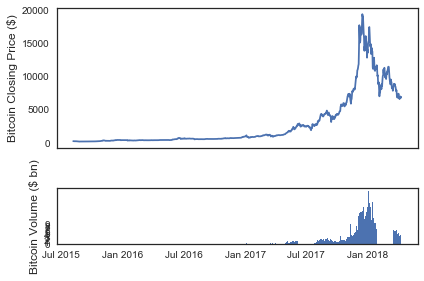

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 2]})
ax1.set_ylabel('Bitcoin Closing Price ($)',fontsize=12)
ax2.set_ylabel('Bitcoin Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
plt.show()

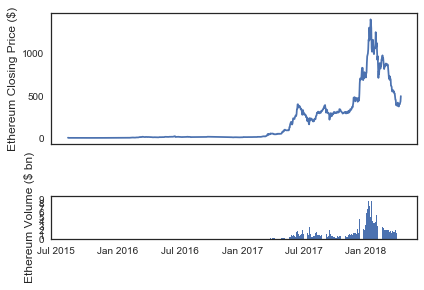

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Ethereum Closing Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
plt.show()

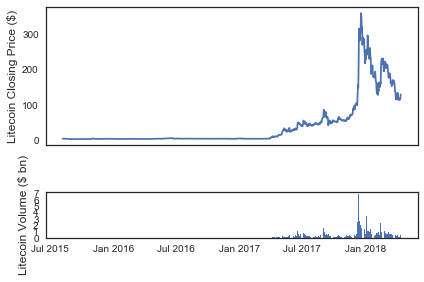

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Litecoin Closing Price ($)',fontsize=12)
ax2.set_ylabel('Litecoin Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(lc_market_info['Date'].astype(datetime.datetime),lc_market_info['lc_Open'])
ax2.bar(lc_market_info['Date'].astype(datetime.datetime).values, lc_market_info['lc_Volume'].values)
fig.tight_layout()
plt.show()

In [11]:
if include_litecoin == 1:
    market_info = pd.merge(bitcoin_market_info, eth_market_info, lt_market_info, on=['Date'])
    coins_list = ['bt_', 'eth_', 'lt_']
else:
    market_info = pd.merge(bitcoin_market_info, eth_market_info, on=['Date'])
    coins_list = ['bt_', 'eth_']
    
    
market_info = market_info[market_info['Date']>=start_date_]

for coins in coins_list: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-04-12,6955.38,7899.23,6806.51,7889.25,8906250000,118048000000,430.16,493.06,417.41,492.94,2519360000,42483600000,0.134266,0.145946
1,2018-04-11,6843.47,6968.32,6817.59,6968.32,4641890000,116126000000,415.02,430.54,412.47,430.54,1439040000,40980200000,0.018244,0.037396
2,2018-04-10,6795.44,6872.41,6704.15,6834.76,4272750000,115306000000,399.41,415.89,393.88,414.24,1196000000,39430400000,0.005786,0.037130
3,2018-04-09,7044.32,7178.11,6661.99,6770.73,4894060000,119516000000,400.86,429.25,390.61,398.53,1478390000,39565100000,-0.038838,-0.005813
4,2018-04-08,6919.98,7111.56,6919.98,7023.52,3652500000,117392000000,385.74,402.59,385.60,400.51,948488000,38065400000,0.014962,0.038290


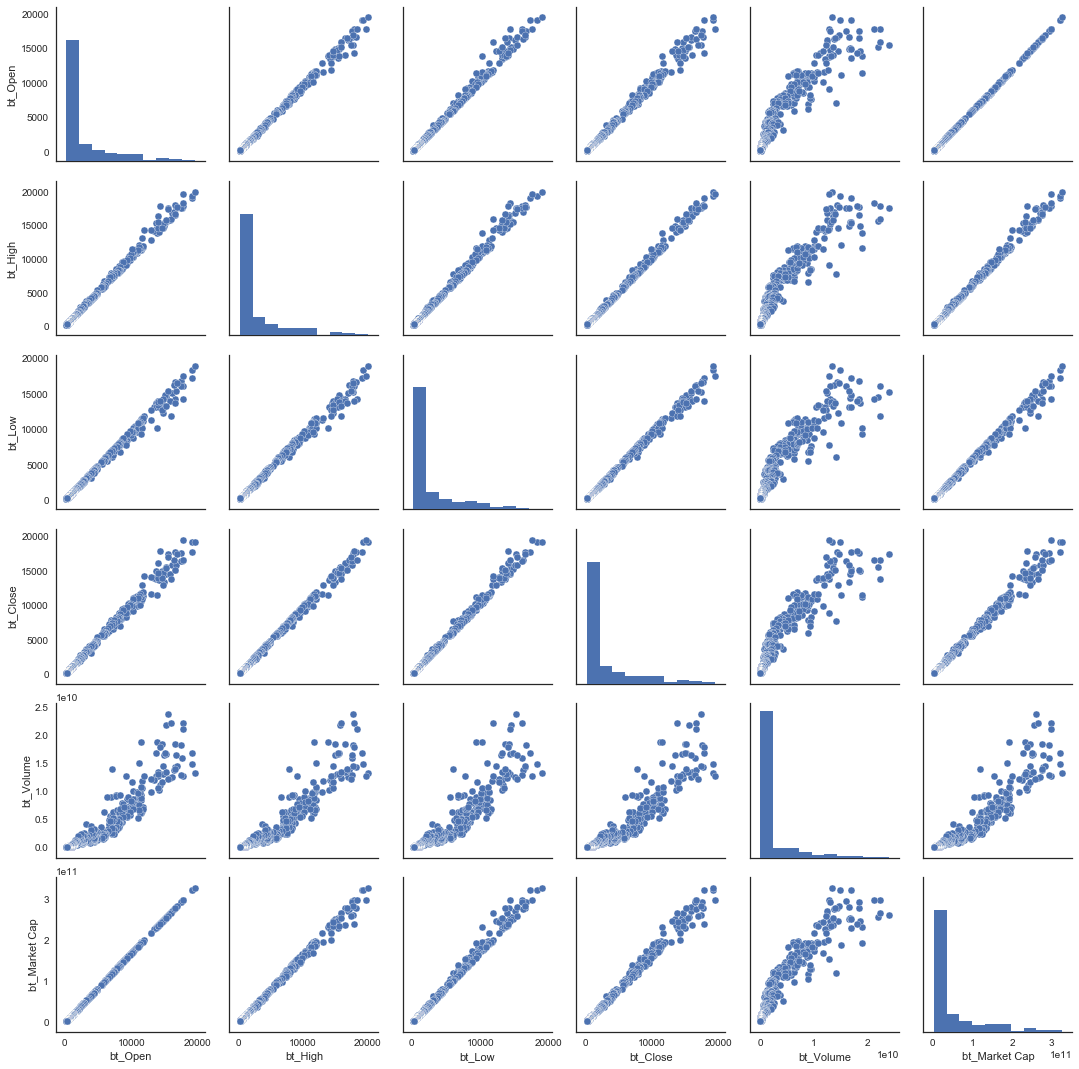

In [12]:
sns.pairplot(bitcoin_market_info)

In [13]:
# Open and Market Cap are directly related. So, one of these could be dropped

In [14]:
print(eth_market_info.columns)

Index(['Date', 'eth_Open', 'eth_High', 'eth_Low', 'eth_Close', 'eth_Volume',
       'eth_Market Cap'],
      dtype='object')


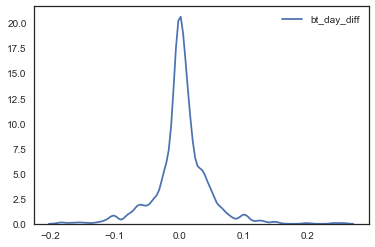

In [15]:
sns.kdeplot(market_info['bt_day_diff'])

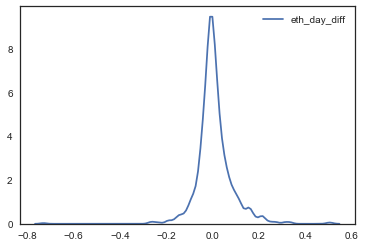

In [16]:
sns.kdeplot(market_info['eth_day_diff'])

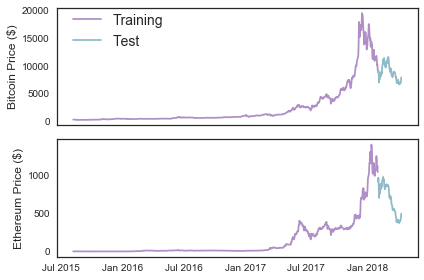

In [17]:
split_date = '2018-02-02'
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
# fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
#              200, 260, zorder=3,alpha=.5)
# fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
#              350, 40, zorder=3,alpha=.5)
plt.show()

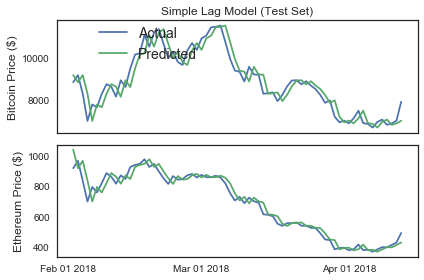

In [18]:
# Persistent model
# trivial Persistence model: P_t = P_(t-1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values, label='Predicted')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close'][1:].values, label='Predicted')
fig.tight_layout()
plt.show()

In [19]:
test_data = market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d')]

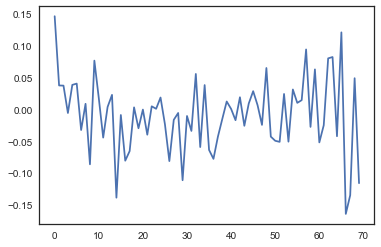

In [20]:
plt.plot(test_data['eth_day_diff'])

In [21]:
actual_bitcoin = market_info[market_info['Date']>= split_date][target].values
print(len(actual_bitcoin))
pred_bitcoin = market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_day_diff'][1:].values
print(len(pred_bitcoin))

# print(actual_bitcoin)
# print(pred_bitcoin)
# print(np.absolute((actual_bitcoin - pred_bitcoin)))

# NOTE: ****** Baseline: no change from previous day => pred_bitcoin = 0 (percent change) for persistence model
mae = np.mean(np.absolute((actual_bitcoin)))
mse = np.mean(np.square((actual_bitcoin)))

# mae = np.mean(np.absolute((actual_bitcoin - pred_bitcoin)))

print(mae)
print(mse)

70
70
0.04413909175923871
0.0030913516180122447


In [22]:
# LSTM begins

# New features
for coins in coins_list: 
    kwargs = { coins+'close_off_high': lambda x: 1-2*(x[coins+'High']-x[coins+'Close'])/(x[coins+'High']-x[coins+'Low']),
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [23]:
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff,bt_close_off_high,bt_volatility,eth_close_off_high,eth_volatility
0,2018-04-12,6955.38,7899.23,6806.51,7889.25,8906250000,118048000000,430.16,493.06,417.41,492.94,2519360000,42483600000,0.134266,0.145946,0.981734,0.157104,0.996827,0.175865
1,2018-04-11,6843.47,6968.32,6817.59,6968.32,4641890000,116126000000,415.02,430.54,412.47,430.54,1439040000,40980200000,0.018244,0.037396,1.000000,0.022025,1.000000,0.043540
2,2018-04-10,6795.44,6872.41,6704.15,6834.76,4272750000,115306000000,399.41,415.89,393.88,414.24,1196000000,39430400000,0.005786,0.037130,0.552478,0.024761,0.850068,0.055106
3,2018-04-09,7044.32,7178.11,6661.99,6770.73,4894060000,119516000000,400.86,429.25,390.61,398.53,1478390000,39565100000,-0.038838,-0.005813,-0.578625,0.073268,-0.590062,0.096393
4,2018-04-08,6919.98,7111.56,6919.98,7023.52,3652500000,117392000000,385.74,402.59,385.60,400.51,948488000,38065400000,0.014962,0.038290,0.080906,0.027685,0.755150,0.044045


In [24]:
model_data = market_info[['Date']+[coin+metric for coin in coins_list 
                                   for metric in ['Close','Volume','close_off_high','volatility', 'day_diff']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,bt_day_diff,eth_Close,eth_Volume,eth_close_off_high,eth_volatility,eth_day_diff
979,2015-08-07,279.58,42484800,0.597015,0.014422,0.003014,2.770000,164329,-0.509804,0.360424,-0.021201
978,2015-08-08,261.00,58533000,-0.969823,0.068707,-0.066991,0.753325,674188,-0.962979,0.747410,-0.729991
977,2015-08-09,265.08,23789600,0.411945,0.025008,0.015165,0.701897,532170,-0.419789,0.354916,-0.006003
976,2015-08-10,264.47,20979400,-0.155756,0.016687,-0.003804,0.708448,405283,0.541175,0.130685,-0.007761
975,2015-08-11,270.39,25433900,1.000000,0.023833,0.022887,1.070000,1463100,0.742911,0.659192,0.511114


In [25]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [26]:
window_len = 25 # 20 10
norm_cols = [coin+metric for coin in coins_list for metric in ['Close','Volume']]

In [27]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

# model output is next price normalised to 10th previous closing price
# LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
LSTM_training_outputs = training_set[target][window_len:].values

In [28]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
# LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1
LSTM_test_outputs = test_set[target][window_len:].values

In [29]:
print(len(training_set))
print(len(test_set))

910
70


In [30]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [31]:
type(LSTM_test_inputs)

numpy.ndarray

In [32]:
import keras
print (keras.__version__)

Using TensorFlow backend.


2.1.4


In [ ]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.5, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(100, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    # model.add(LSTM(25, return_sequences=True))
    # model.add(Dropout(dropout))
    model.add(LSTM(10))
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 1000)

# note: bt_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=15, batch_size=1, verbose=2, shuffle=True)

Epoch 1/15
 - 18s - loss: 0.0574
Epoch 2/15
 - 15s - loss: 0.0321
Epoch 3/15
 - 16s - loss: 0.0274
Epoch 4/15
 - 16s - loss: 0.0262
Epoch 5/15
 - 15s - loss: 0.0257
Epoch 6/15
 - 15s - loss: 0.0255
Epoch 7/15
 - 15s - loss: 0.0253
Epoch 8/15


In [ ]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(bt_history.epoch, bt_history.history['loss'])
ax1.set_title('Training Error')

if bt_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1,1)
LSTM_test_outputs = training_set[target][window_len:].values
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         (bt_model.predict(LSTM_test_inputs)), 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs(bt_model.predict(LSTM_test_inputs)-\
            (test_set[target].values[window_len:]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price change (%)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         (bt_model.predict(LSTM_training_inputs)), 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs(bt_model.predict(LSTM_training_inputs)-\
            (training_set[target].values[window_len:]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Training Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [ ]:
pred_values = bt_model.predict(LSTM_training_inputs)

In [ ]:
max(pred_values)

In [ ]:
min(pred_values)

In [ ]:
# Notes:
# Include other currencies (ripple, litecoin, bitcoin cash?) - Ideally, pre-cluster 1600+ currencies and find the ones of interest
# Predicting price Vs percent change? Does LSTM make sense for predicting percent-change?
# 
# Window size; # of neurons; # of layers; 
# Split date?